# Image Compression and Classification using Tucker Decomposition

*images*, *tensor decomposition*, *tucker decomposition*, *dimension reduction*, *classification*

**Problem**

We want to perform image classification. Each sample, i.e. an image, is high-dimensional. Thus, raw images cannot be directly used as inputs for conventional classification models. Thus, dimension reduction is needed. Coefficient reduction is a key element of many data compression algorithms. Under this concept, and after 
computing a transform of the input data, the least significant coefficients are eliminated in order to decrease
the total memory needs. 


**Method**

We can treat a batch of images as a tensor $\mathcal{X} \in \mathbb{R}^{I x J x K}$. We use Tucker decomposition for dimensionality reduction and compact multidimensional data representation. **Tucker Decomposition** decomposes a tensor into a core tensor multiplied (or transformed) by a set of factorizing matrix along each mode. For example, a 3-order tensor $\mathcal{X} \in \mathbb{R}^{I x J x K}$, 

$$
$\mathcal{X} \approx \mathcal{G} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C}  
= \sum^P_{p=1}  \sum^Q_{q=1}  \sum^R_{r=1} g_{pqr} \mathbf{a}_p \circ  \mathbf{b}_q \circ   \mathbf{c}_r  
= [\![ \mathcal{G}; \mathbf{A},\mathbf{B},\mathbf{C} ]\!]
$$
where $\mathbf{A} \in \mathbf{R}^{I x P}, \mathbf{B} \in \mathbf{R}^{K x R}, \mathbf{C} \in \mathbf{R}^{K x R}, \mathcal{G} \in \mathbf{R}^{P x Q x R}$.

Pictorially,

![image info](supplements/tucker_image.png)

The core tensor capures the interaction among different modes and since often $P<I, Q<J, R<I$, the core tensor is considered as the compressed version of the original tensor. Thus, dimension reduction is achieved. In most cases, it is assumed that factor matrices are column-wise orthogonal. CP decomposition can be seen as a special case of Tucker where the core matrix is super-diagonal and $P=Q=R$.

The optimization problem is

$$
\min_{\mathcal{G}; \mathbf{A}^{(1)}, \dots, \mathbf{A}^{(n)}} \| \mathcal{X} - [\![  \mathcal{G};  \mathbf{A}^{(1)}, \dots, \mathbf{A}^{(n)} ]\!] \|^2
$$
$$
s.t. \mathcal{G} \in \mathbb{R}^{R_1 \times \dots \times R_n}; \mathbf{A}^{(k)} \in \mathbb{R}^{I_k \times R_k}, \mathbf{A}^{(k)} \text{ column wise orthogonal for all k} 
$$ 

There are two common ways to solve Tucker Decomposition. 
* Method 1: Higher Order Singular Value Decomposition (HOSVD): the idea is to find the factor matrices for each mode separately such that the maximum variation of  the mode is captured. However, this method is not optimal because it does not consider all interrelationships between all the modes. 
* Method 2: Alternating Least Squares (ALS): the idea is to solve one $\mathbf{A}^{(k)}$ at a time while fixing other modes. The pseudo code is below


![image info](supplements/tucker_als_algorithm.png)

Next, we implement both methods from scratch. We perform Tucker decomposition on the training images and apply the learnt loadings on test images. We use the core matrices to train the classification model.


## Implementing Tucker Decomposition from Scratch

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import tensorly as tl
import tensorly.decomposition
from scipy.io import loadmat
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# tensor matricization in Tensorly is different from the Kolda's paper 
# http://jeankossaifi.com/blog/unfolding.html

def tensor_matricization(X):
    n0,n1,n2 = X.shape

    # mode 1
    X1 = np.zeros((n1, n0*n2))
    for i in range(n0):
        X1[:, i*n2:((i+1)*n2)] = X[i,:,:]

    # mode 2
    X2 = np.zeros((n2, n0*n1))
    for i in range(n0):
        X2[:, i*n1:((i+1)*n1)] = X[i,:,:].T

    # mode 3
    X3 = np.zeros((n0, n2*n1))
    count = 0
    for j in range(n2):
        for i in range(n1):
            X3[:, count] = X[:,i,j]
            count += 1
            
    return X3, X1, X2  

In [961]:
def tucker_decomposition_hosvd(X, R):
    
    modes = np.arange(len(X.shape))
    A = []

    # find factor matrices for each mode separately 
    for mode in modes:
        U, S, Vh = np.linalg.svd(tl.unfold(X, mode), full_matrices=True) # 2D matrix
        A.append(U[:, :R[mode]])  # (I, Ri)
    G = tl.tenalg.multi_mode_dot(X, A, modes=modes, transpose=True)        
        
    return G, A

In [962]:
def tucker_decomposition_als(X, R, max_iter=100, verbose=False, thd=1e-6, init='svd', thresholding=None):

    # initialize factor matrices for each mode 
    modes = [i for i in range(len(X.shape))]
    if init == 'svd':
        G, A = tucker_decomposition_hosvd(X, R)
    else:
        G = np.random.random(R)
        A = []
        for mode in modes:
            A.append(np.random.random((X.shape[mode], R[mode]))) # (I,R) (J,R) (K,R)

    loss, prev_loss = 1e3, 1e6
    for epoch in range(max_iter):
        
        # ALS 
        for mode in modes:
            Y = tl.tenalg.multi_mode_dot(X, A[:mode]+A[mode+1:], 
                  modes=modes[:mode]+modes[mode+1:], transpose=True) # (R1,R2...)
            U, S, Vh = np.linalg.svd(tl.unfold(Y, mode), full_matrices=True) 
            A[mode] = U[:, :R[mode]]    # (I, Ri)
        G = tl.tenalg.multi_mode_dot(X, A, modes=modes, transpose=True)        
        
        # stopping criteria 
        X_ = tl.tenalg.multi_mode_dot(G, A, modes=modes, transpose=False)      
        loss = np.linalg.norm(X_ - X)
        if verbose and epoch % 10 == 0:
            print("Epoch:", epoch, "| loss:", loss)
        if np.abs(loss - prev_loss) < thd: break 
        prev_loss = loss
      
    if verbose: print("converged, number of epochs:", epoch, "loss:", loss)
    
    if thresholding is not None:
        thd = np.percentile(np.abs(G), thresholding)
        G *= (np.abs(G) > thd)
        if verbose: print("threshold:", thresholding, "%:", thd)
        
    return G, A

## Image Compression

`ATT.mat` contains a third order tensor of 20 images. We will test the Tucker decomposition for dimension reduction. 

**Hard thresholding**

We perform hard thresholding on the core tensor by considering five cases. We keep only 10%, 20%, 30%,
40% and 50% of the core tensor coefficients, possessing the largest absolute value and set the rest
to zero. We report the relative error for each case as:

$$
\epsilon = \frac{\sqrt{ \| \mathcal{A} \|^2  - \| \mathcal{B} \|^2 }} { \| \mathcal{A} \| }
$$
where $\|. \|$ is the Frobenius norm, $\mathcal{A}$ is the original image, and $\mathcal{B}$ is the core tensor.

In [959]:
# read in data
data = loadmat('data/ATT.mat')
X = data['A']
X.shape

(56, 46, 20)

In [963]:
# self-implemented 
R = [30, 30, 20]
G, A = tucker_decomposition_als(X, R, verbose=False)
X_ = tl.tenalg.multi_mode_dot(G, A, modes=modes, transpose=False)        
eps = np.round(np.sqrt(np.linalg.norm(X)**2 - np.linalg.norm(G)**2) / np.linalg.norm(X),4)
print("relative error:", eps)

relative error: 0.0424


In [964]:
# package implementation 
G_, A_ = tl.decomposition.tucker(X.astype(float), R)
eps = np.round(np.sqrt(np.linalg.norm(X)**2 - np.linalg.norm(G_)**2) / np.linalg.norm(X),4)
print("relative error:", eps)

relative error: 0.0424


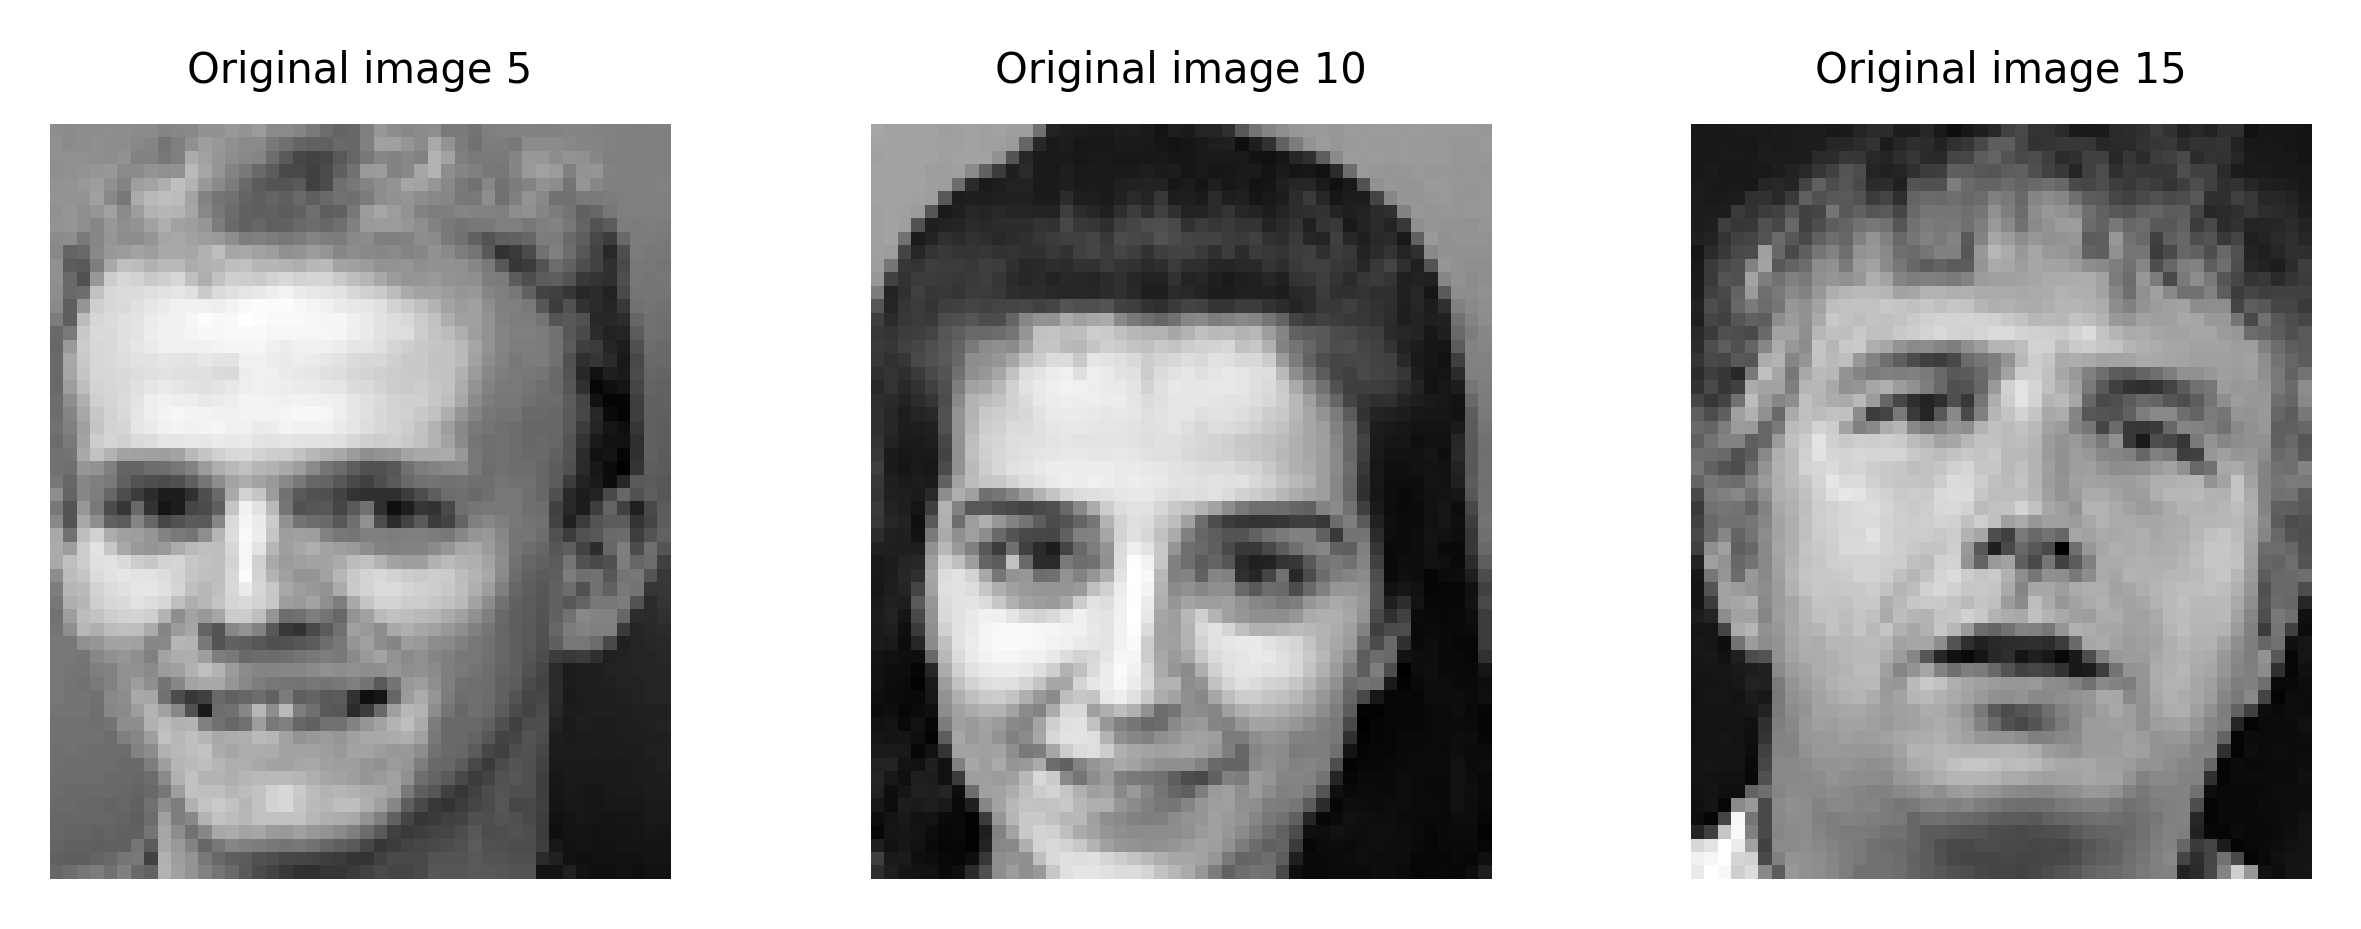

In [970]:
# visualize
images = [4,9,14]
fig, ax = plt.subplots(1,3, figsize=(6,2))
for i in range(len(images)):
    ax[i].imshow(X[:,:,images[i]], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title('Original image ' + str(images[i]+1), size=6)
plt.show()

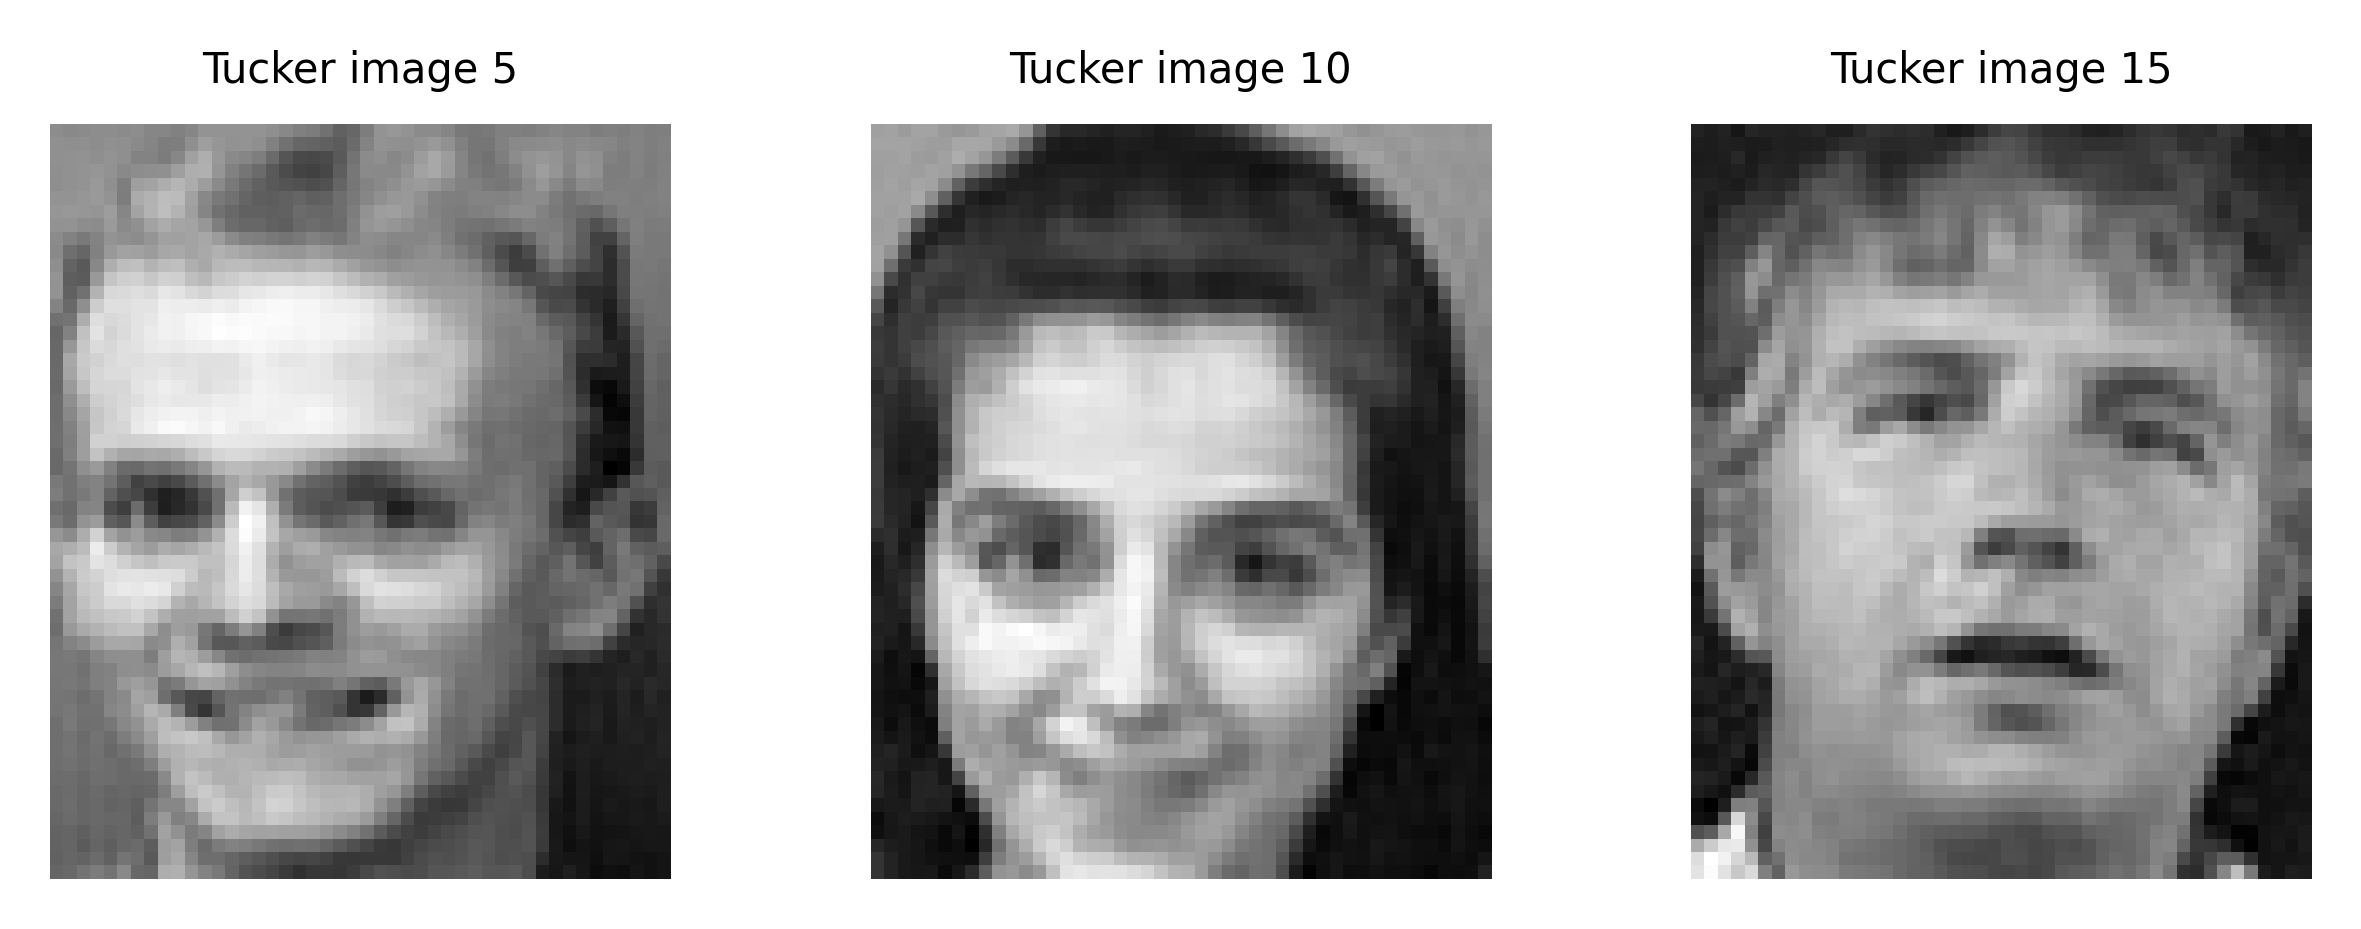

In [971]:
fig, ax = plt.subplots(1,3, figsize=(6,2))
for i in range(len(images)):
    ax[i].imshow(X_[:,:,images[i]], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title('Tucker image ' + str(images[i]+1), size=6)
plt.show()

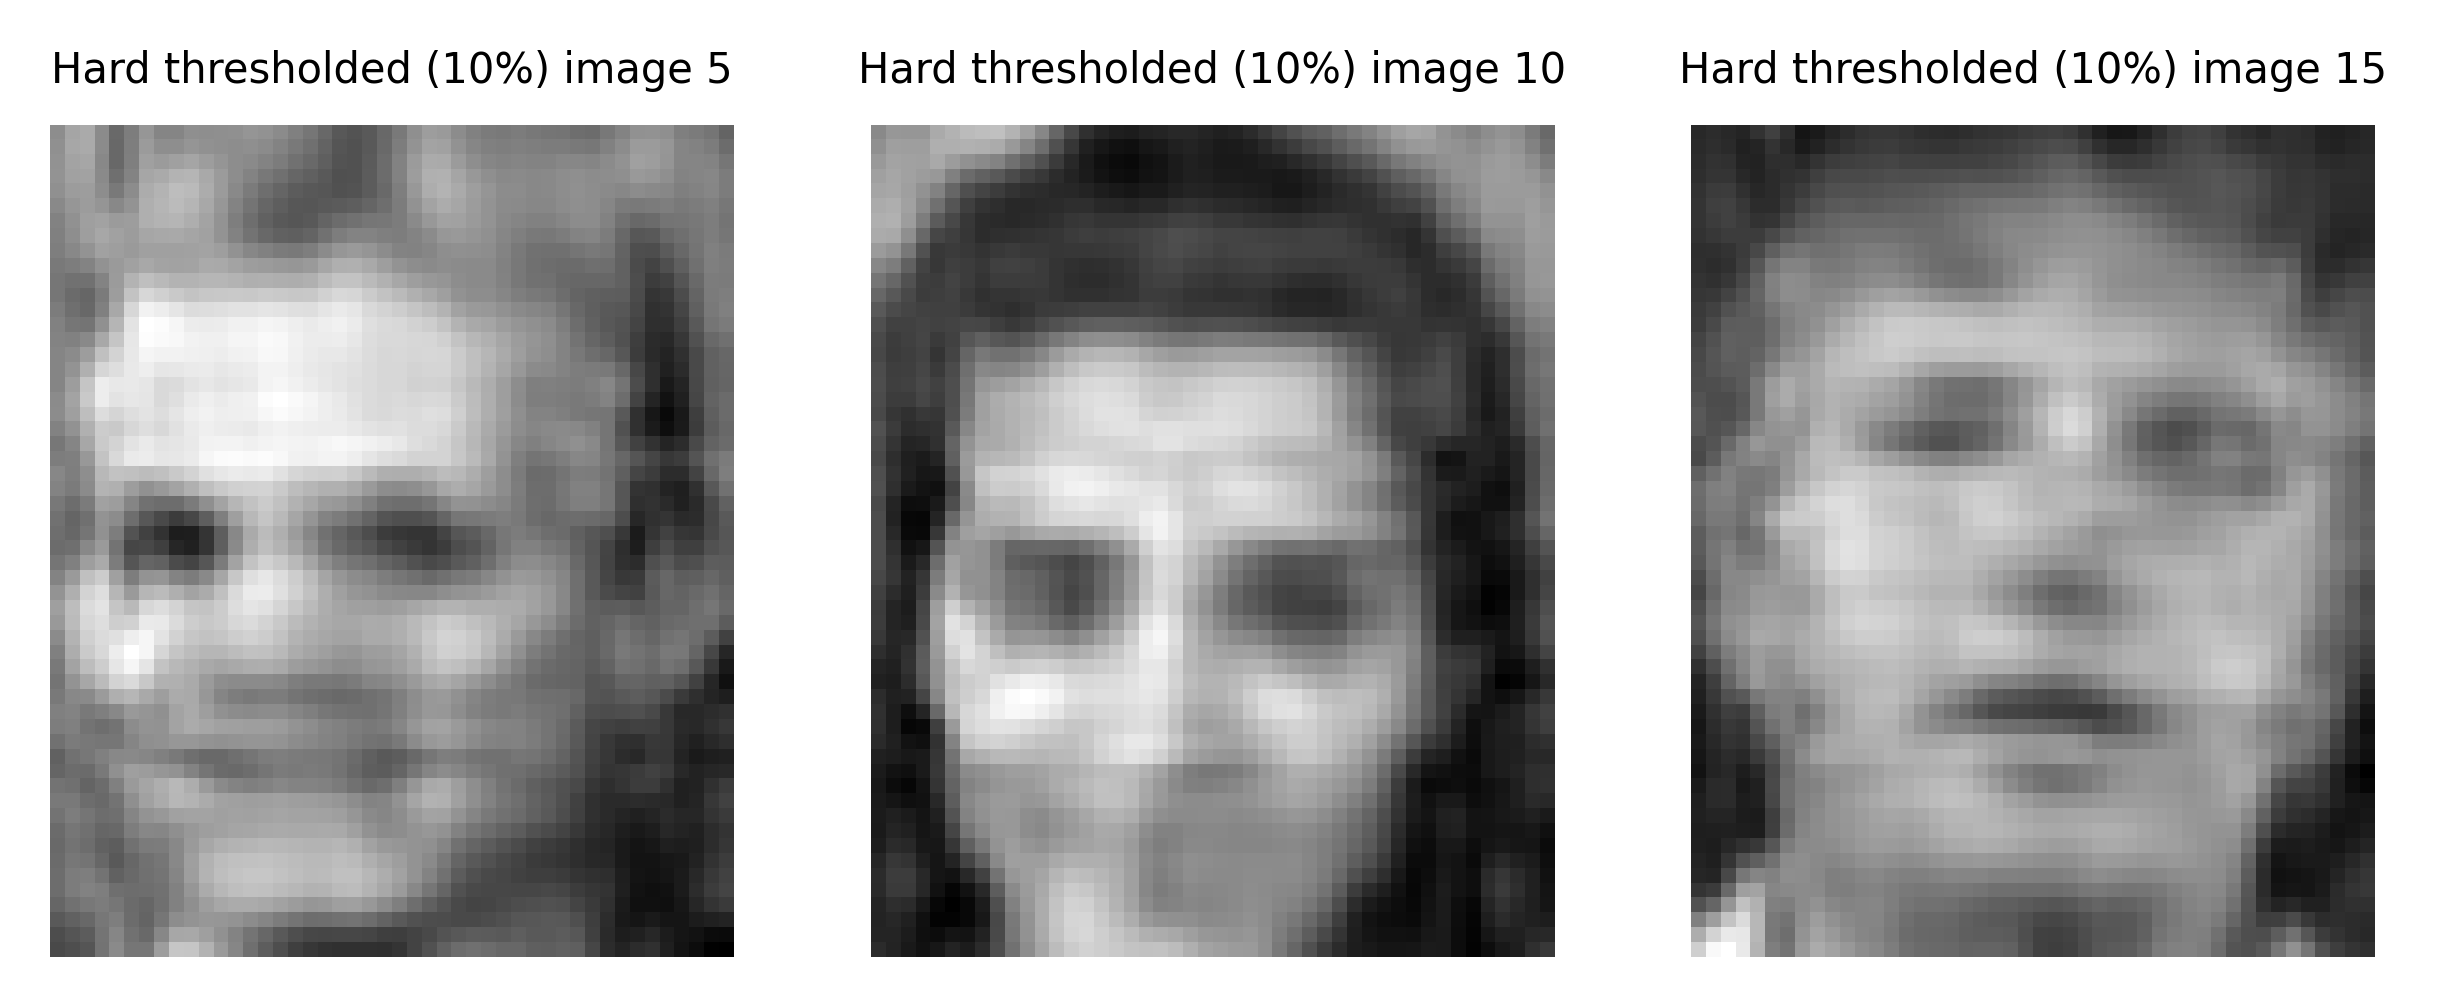

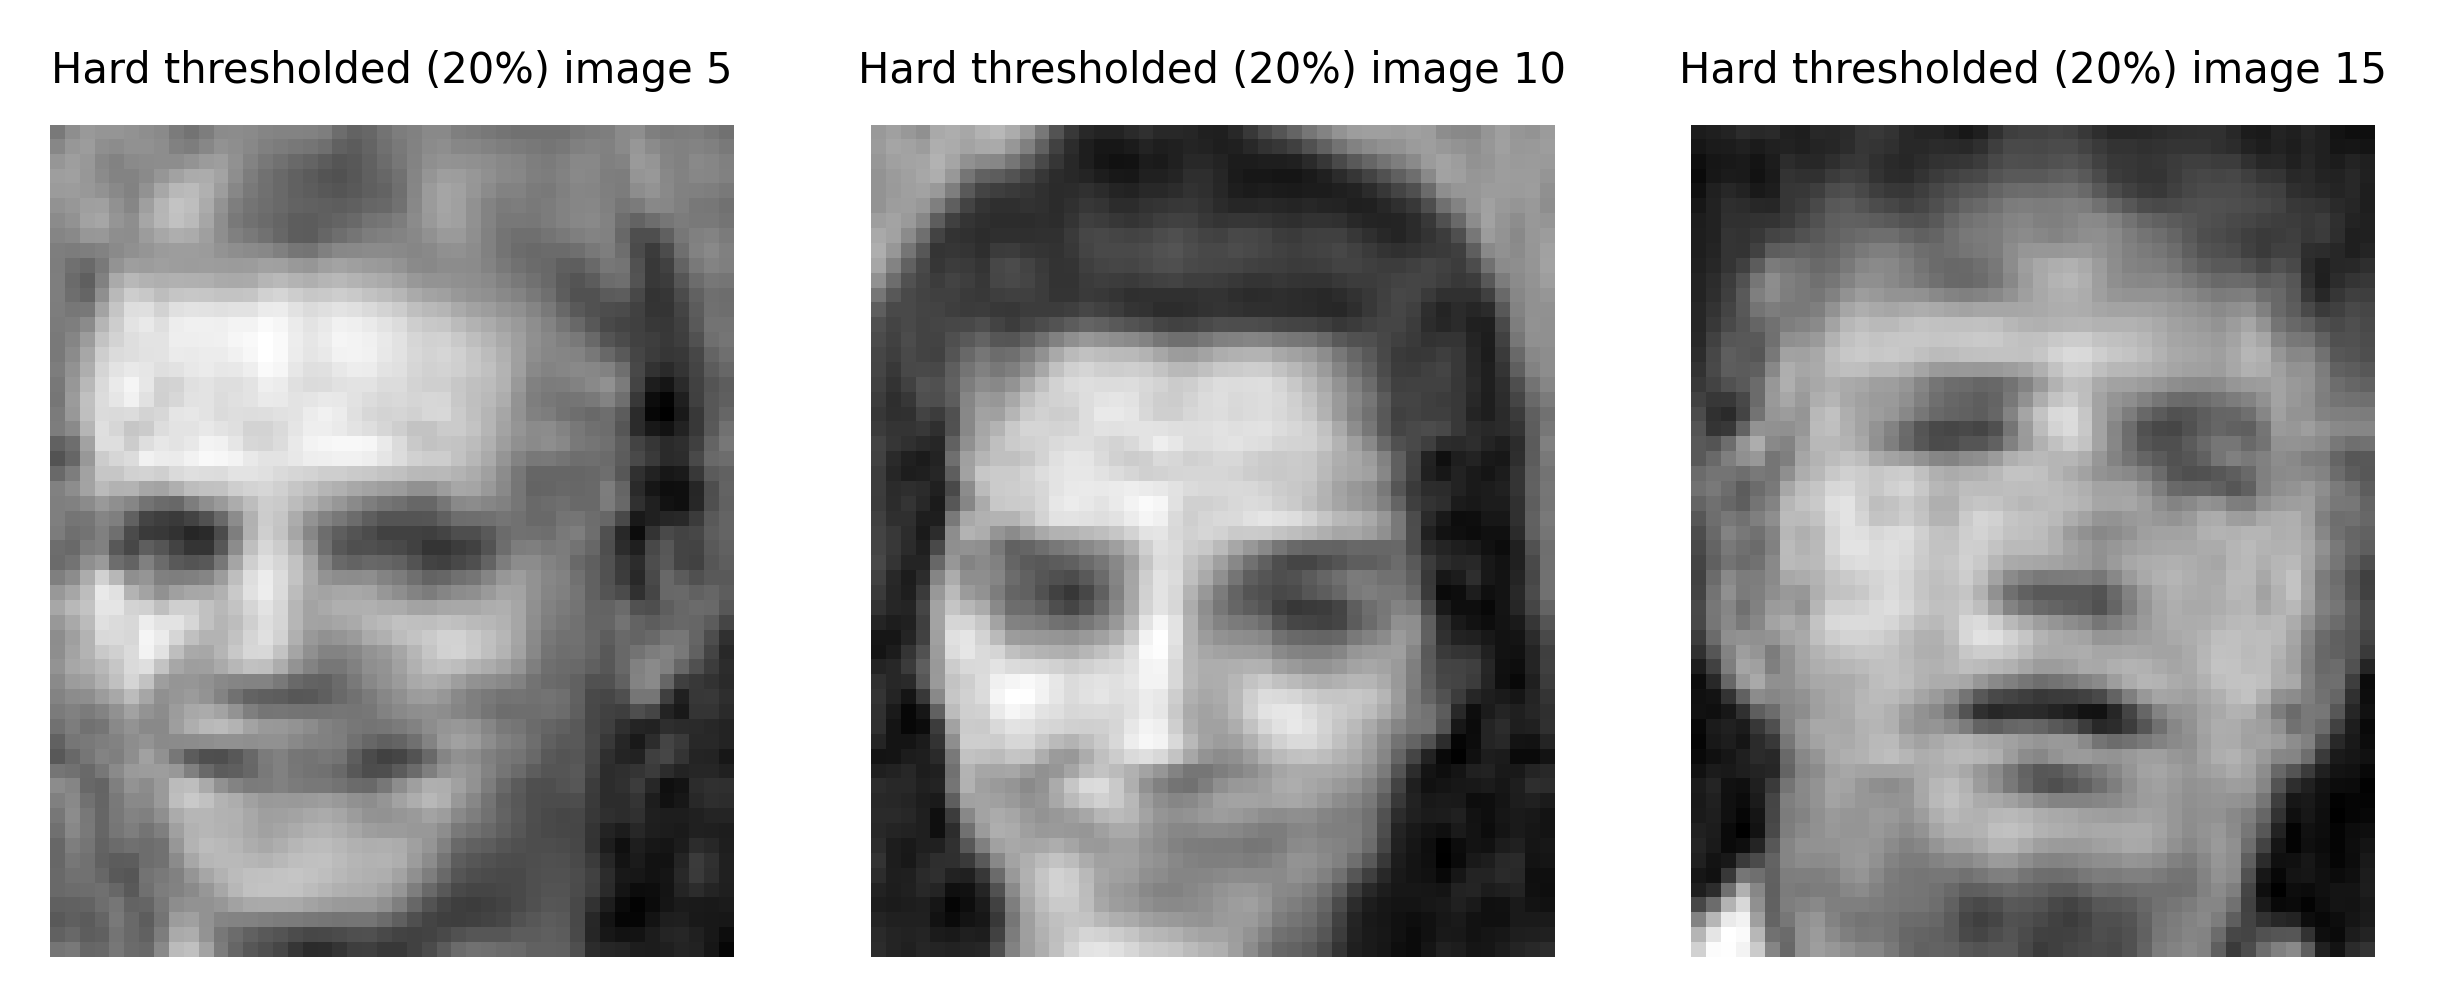

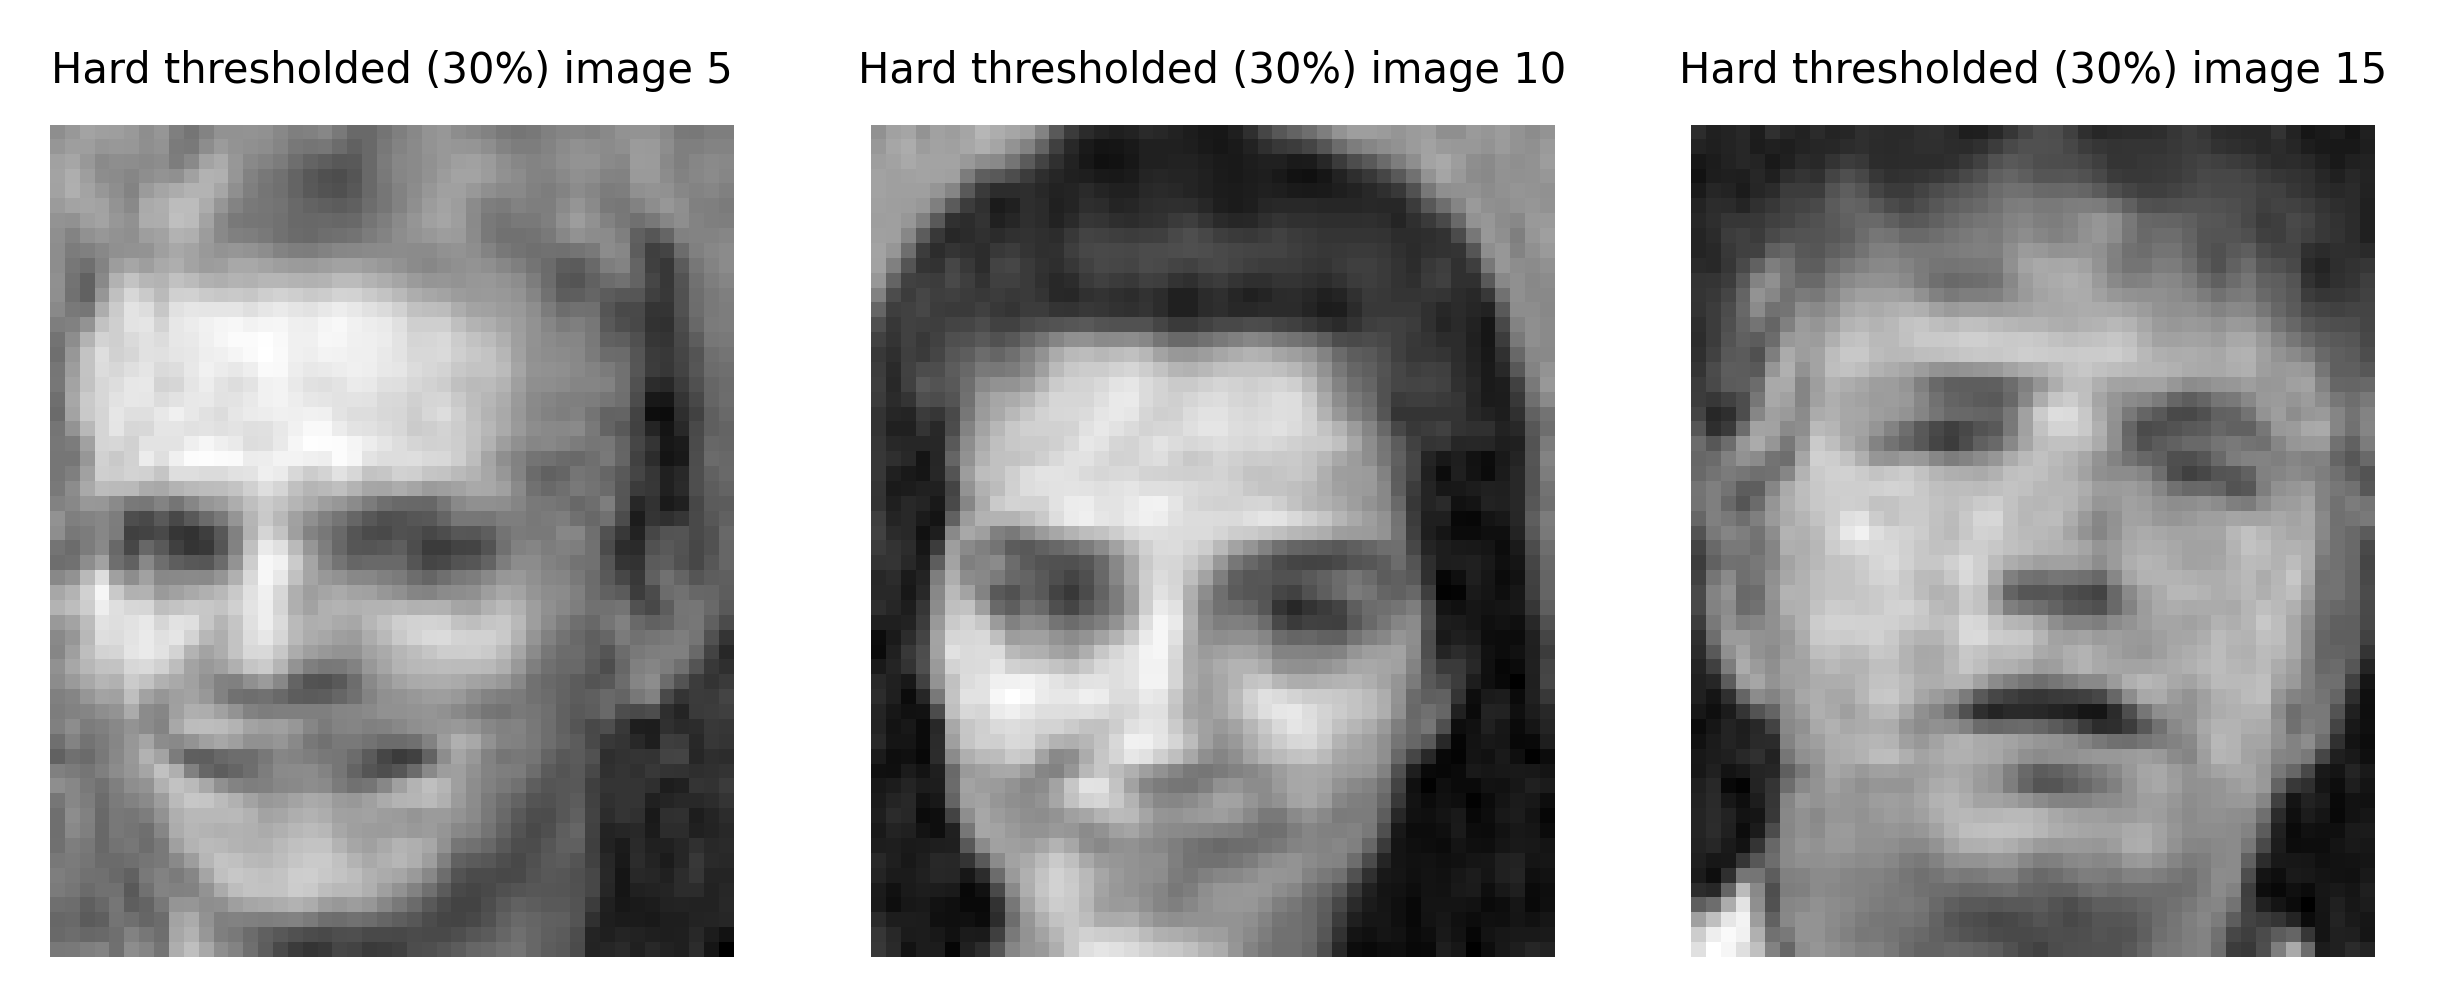

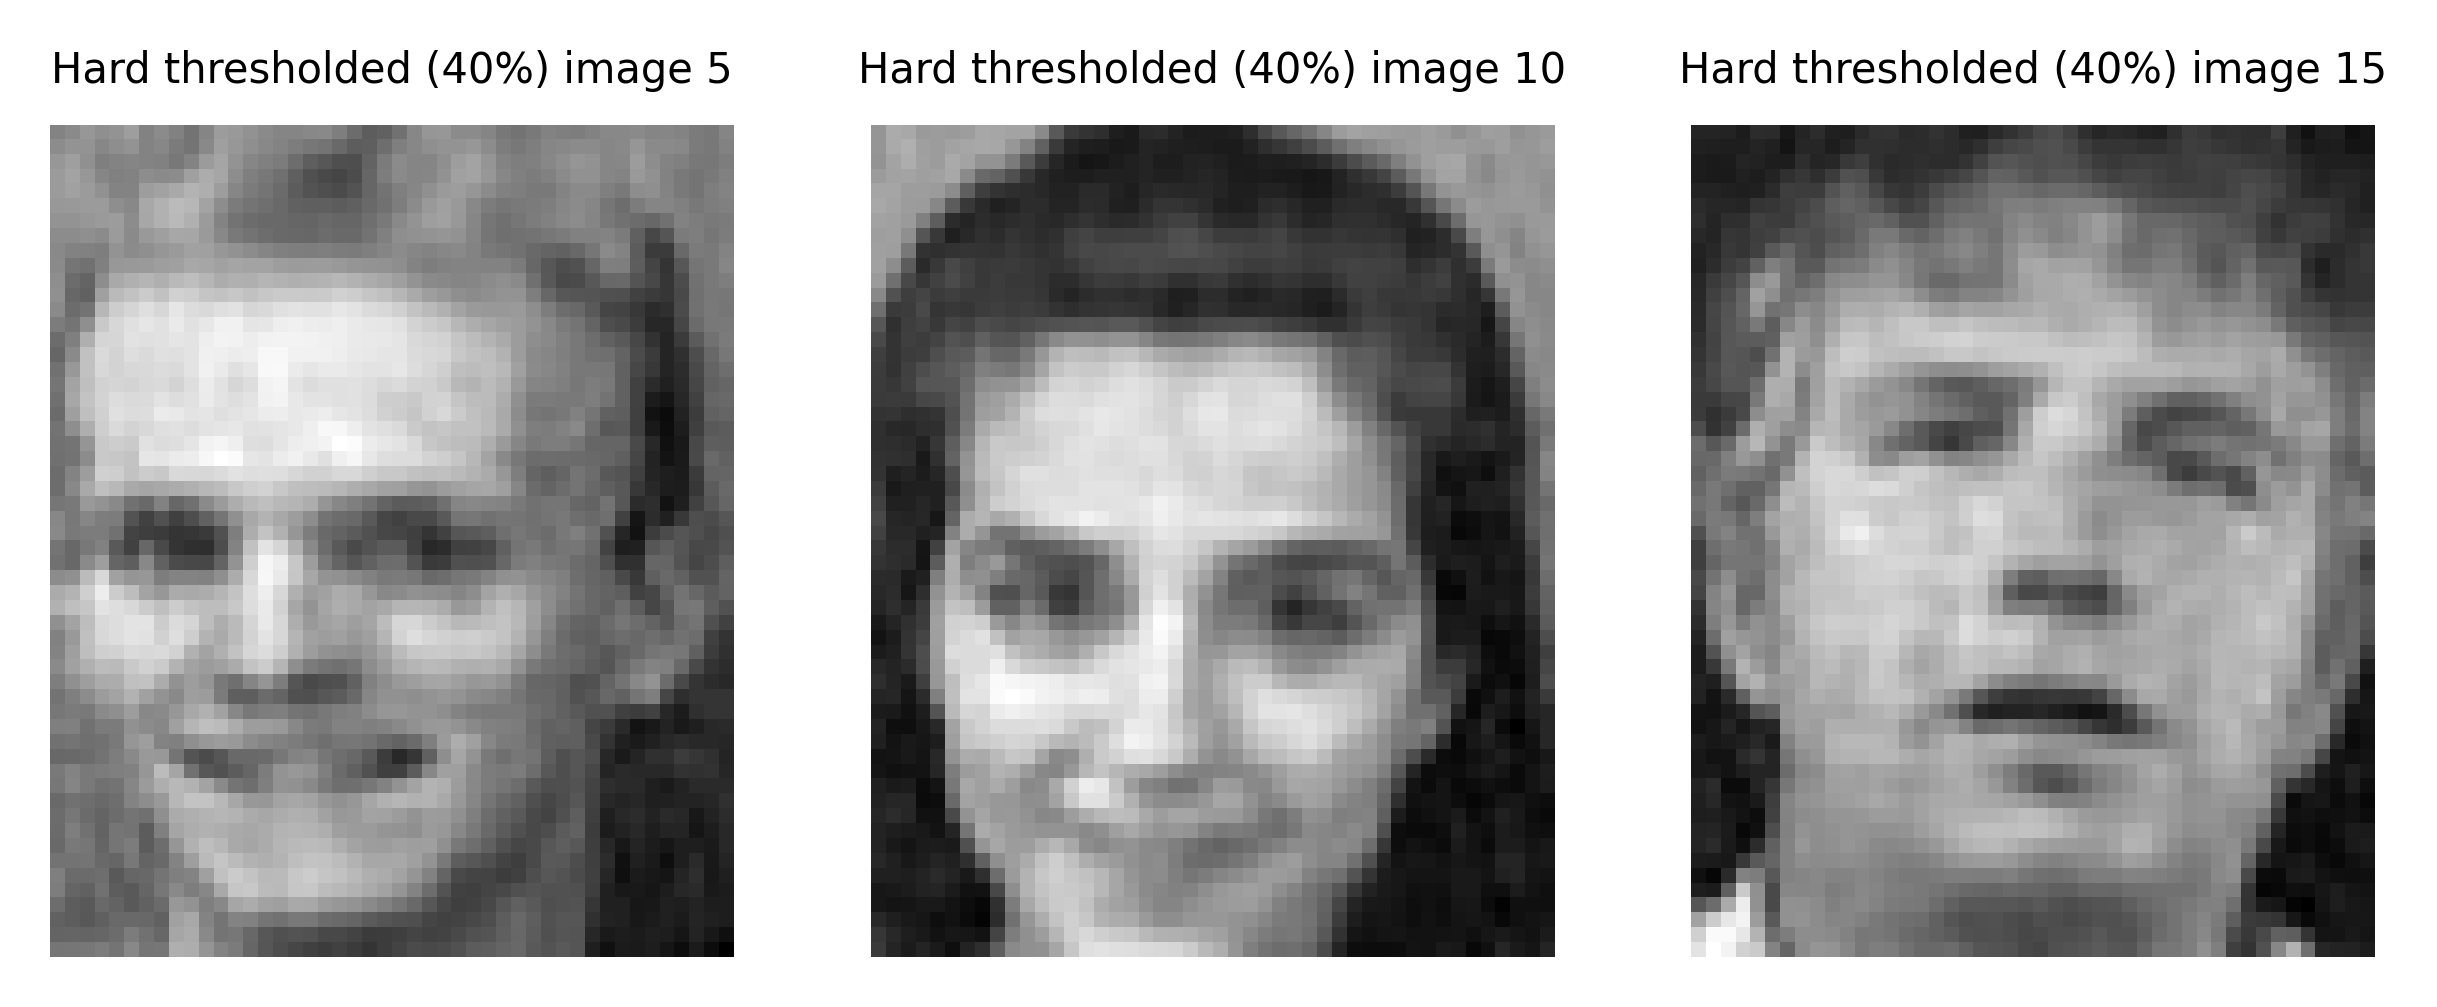

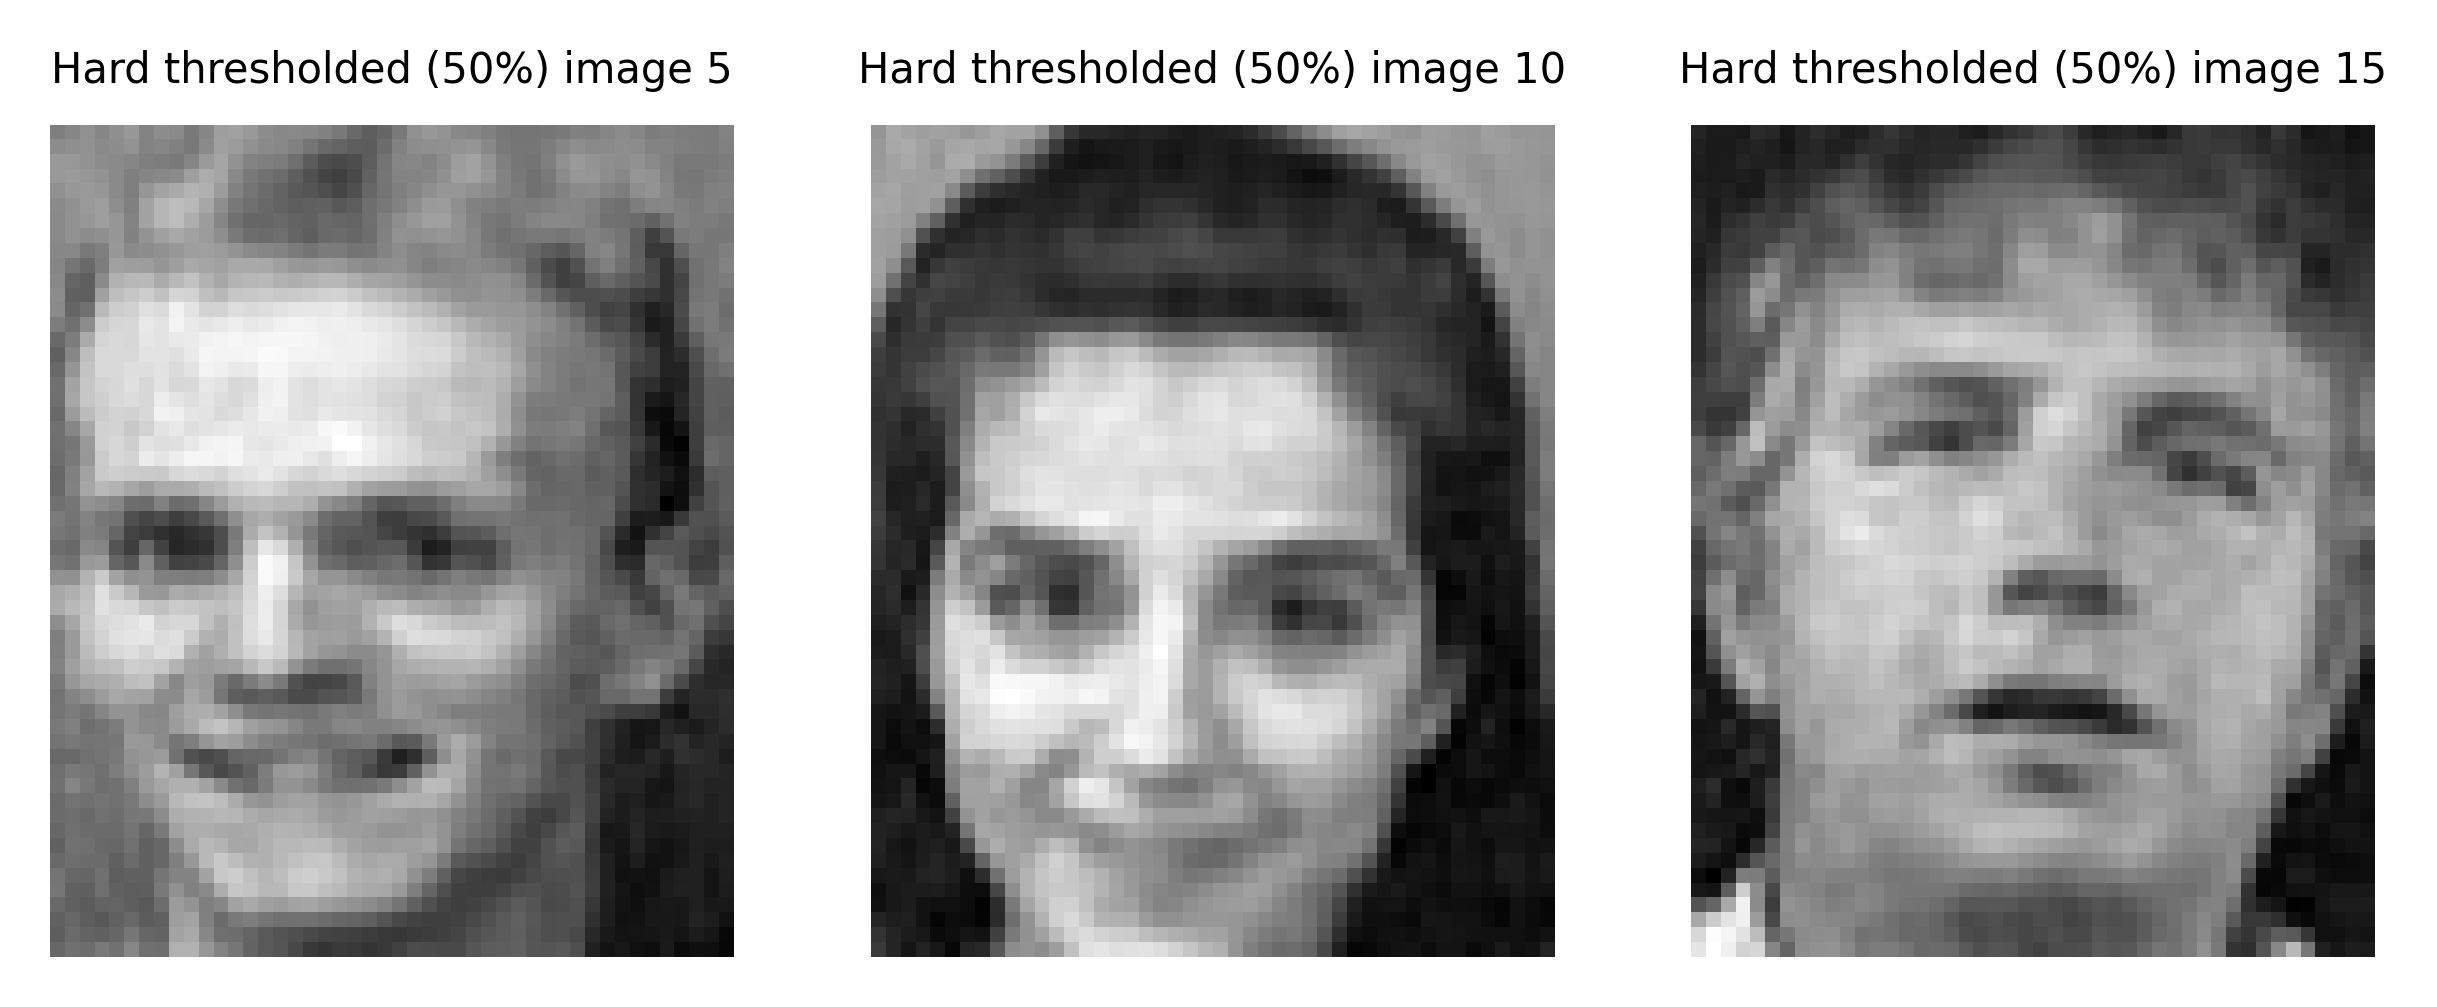

In [969]:
# thresholded 
for thd in [10,20,30,40,50]:
    
    G, A = tucker_decomposition_als(X, R, verbose=False, thresholding=100-thd)
    X__ = tl.tenalg.multi_mode_dot(G, A, modes=modes, transpose=False)        

    fig, ax = plt.subplots(1,3, figsize=(6,3))
    for i in range(len(images)):
        ax[i].imshow(X__[:,:,images[i]], cmap='gray')
        ax[i].axis('off')
        ax[i].set_title('Hard thresholded (' + str(thd) + '%) image ' + str(images[i]+1), size=6)
    plt.show()

## Image Classification

We learn a classifier that classifies images as cats or birds. The training data consists of 28 images `train1.jpg` through `train28.jpg`. Each image is `500 x 500`. The goal is to achieve good performance on test data of 12 new images, `test1.jpg` through `test12.jpg`. 

Using Tucker decomposition, each image $X^{(k)}$ of `500 x 500` can be expressed as

$$X^{(k)} \approx G^{(k)} \times_1 A^{(1)} \times_2 \dots \times_N A^{(N)}, k=1 \dots, K $$

where in this case, $A^{(1)}$ is `500 x 10`,  $A^{(2)}$ is `500 x 10`, and  $A^{(3)}$ is `28 x 28`; $G^{(k)}$ is a `10 x 10` core matrix. We will vectorize $G$ to be used as a `100 x 1` feature vector for classification. 

To extract features for a test sample $t$, we simply compute 

$$ G^{(t)} = X^{(t)} \times_1 {A^{(1)}}^T \times_2 \dots \times_N {A^{(N)}}^T, k=1 \dots, K $$

If image is color, it adds one additional dimension to the data. We compare the classification accuracy using both color and gray images. We use random forest as the classifier. 

## Part 1: Classification using gray images

In [972]:
# read in data
images_train = []
for i in range(1,29):
    image = plt.imread('data/CatsBirds/train' + str(i) + '.jpg')
    gray_image = np.mean(image, axis=2)
    images_train.append(gray_image)

images_test = []
for i in range(1,13):
    image = plt.imread('data/CatsBirds/Test' + str(i) + '.jpg')
    gray_image = np.mean(image, axis=2)
    images_test.append(gray_image) 
    
labels = loadmat('data/train_lab.mat')
y_train = labels['data/train'].flatten()
y_test = np.asarray([1,1,0,1,0,1,0,0,1,0,0,1])

In [973]:
# create a third-order tensor by stacking the gray images
X_train = np.asarray(images_train)
X_train = np.swapaxes(np.swapaxes(X_train,0,1),1,2)
X_train.shape

# alternative
# t = np.zeros([500,500,28])
# for i in range(28):
#     t[:,:,i]=X_train[i,:,:]

(500, 500, 28)

Note that we organized images as frontal slices, so the factor matrix of the last node only captures ordeing information. We do not want to use this information when doing classification. So we multiply back the last factor to the core tensor.

In [974]:
# tucker decomposition 
R = [10, 10, 28]
G_train, A = tl.decomposition.tucker(X_train.astype(float), R)

# remove the last factor from the core matrix
G_train = tl.tenalg.mode_dot(G_train, A[-1], mode=2)

# extract features from test data 
G_test = [] 
for i in range(len(images_test)):
    t = tl.tenalg.multi_mode_dot(images_test[i].astype(float), A[:-1], transpose=True)
    G_test.append(t) 
G_test = np.asarray(G_test)
G_test = np.swapaxes(np.swapaxes(G_test,0,1),1,2)
G_test.shape

(10, 10, 12)

Visualize the Tucker compressed images to check that the algorihtm is working. It is expected that the tucker image is blurry. We reduced the dimensions from `500 x 500 = 250000` to `10x10=100` for each image.

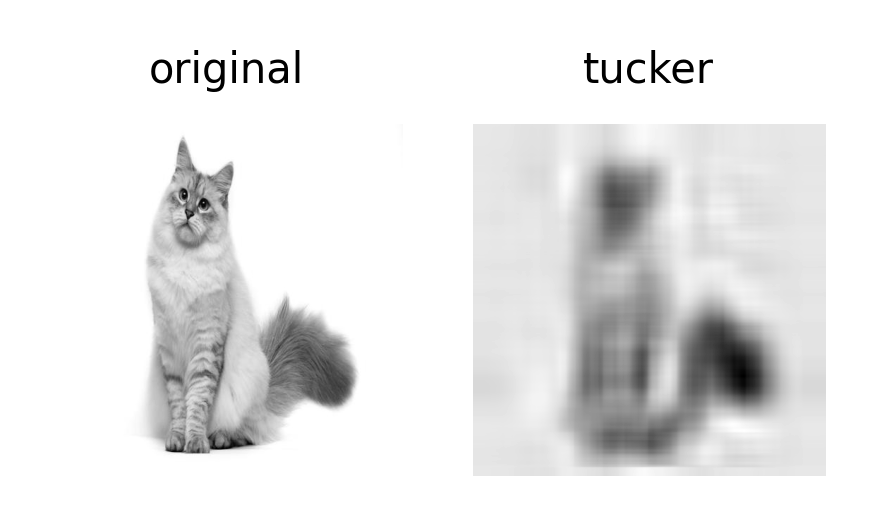

In [975]:
# visualize one training image to check 
matplotlib.rcParams['figure.figsize'] = (6,3)

X_train_ = tl.tenalg.multi_mode_dot(G_train[:,:,0], A[:-1], transpose=False)  
fig, ax = plt.subplots(1,2, figsize=(2,1))
ax[0].imshow(images_train[0], cmap='gray')
ax[0].axis('off')
ax[0].set_title('original', size=6)
ax[1].imshow(X_train_, cmap='gray')
ax[1].axis('off')
ax[1].set_title('tucker', size=6)
plt.show()

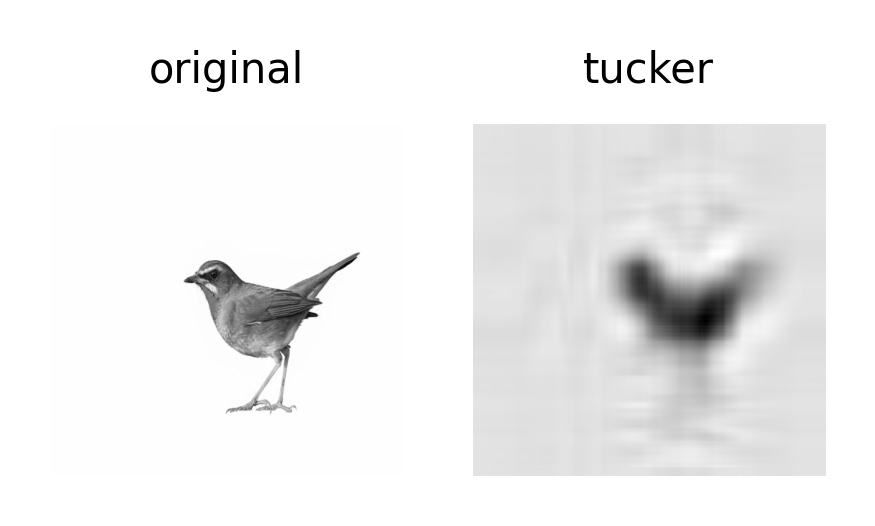

In [976]:
# visualize one test image to check 
X_test_ = tl.tenalg.multi_mode_dot(G_test[:,:,0], A[:-1], transpose=False)  
fig, ax = plt.subplots(1,2, figsize=(2,1))
ax[0].imshow(images_test[0], cmap='gray')
ax[0].axis('off')
ax[0].set_title('original', size=6)
ax[1].imshow(X_test_, cmap='gray')
ax[1].axis('off')
ax[1].set_title('tucker', size=6)
plt.show()

In [977]:
# reshape core matrix into a vector to be used as features 
G_train = G_train.reshape(100, G_train.shape[2]).T  
G_test = G_test.reshape(100, G_test.shape[2]).T
# 28 samples, each has 100 features 

In [923]:
# train random forest classifier 
model = RandomForestClassifier(random_state=1, n_estimators=100) 
model.fit(G_train, y_train)

# predict on test data
pred_train = model.predict(G_train)
pred_test = model.predict(G_test)
print("Train accuracy:", np.sum(pred_train == y_train) / y_train.shape[0])
print("Test accuracy:", np.round(np.sum(pred_test == y_test) / y_test.shape[0],2))
confusion_matrix(y_test, pred_test)

Train accuracy: 1.0
Test accuracy: 0.92


array([[6, 0],
       [1, 5]])

## Part 2: Classification using Color images

In [978]:
# read in data
images_train = []
for i in range(1,29):
    image = plt.imread('data/CatsBirds/train' + str(i) + '.jpg')
    images_train.append(image)

images_test = []
for i in range(1,13):
    image = plt.imread('data/CatsBirds/Test' + str(i) + '.jpg')
    images_test.append(image) 
    
labels = loadmat('data/train_lab.mat')
y_train = labels['data/train'].flatten()
y_test = np.asarray([1,1,0,1,0,1,0,0,1,0,0,1])

In [979]:
# create a fourth-order tensor by stacking the gray images
X_train = np.asarray(images_train)
X_train = np.swapaxes(np.swapaxes(np.swapaxes(X_train,0,1),1,2),2,3)
X_train.shape

(500, 500, 3, 28)

In [980]:
# tucker decomposition 
R = [10, 10, 3, 28]
G_train, A = tl.decomposition.tucker(X_train.astype(float), R)

# remove the last factor from the core matrix
G_train = tl.tenalg.mode_dot(G_train, A[-1], mode=3)

# extra features from test data 
G_test = [] 
for i in range(len(images_test)):
    G_test.append(tl.tenalg.multi_mode_dot(images_test[i].astype(float), A[:-1], transpose=True))
G_test = np.asarray(G_test)
G_test = np.swapaxes(np.swapaxes(np.swapaxes(G_test,0,1),1,2),2,3) 
G_test.shape

(10, 10, 3, 12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


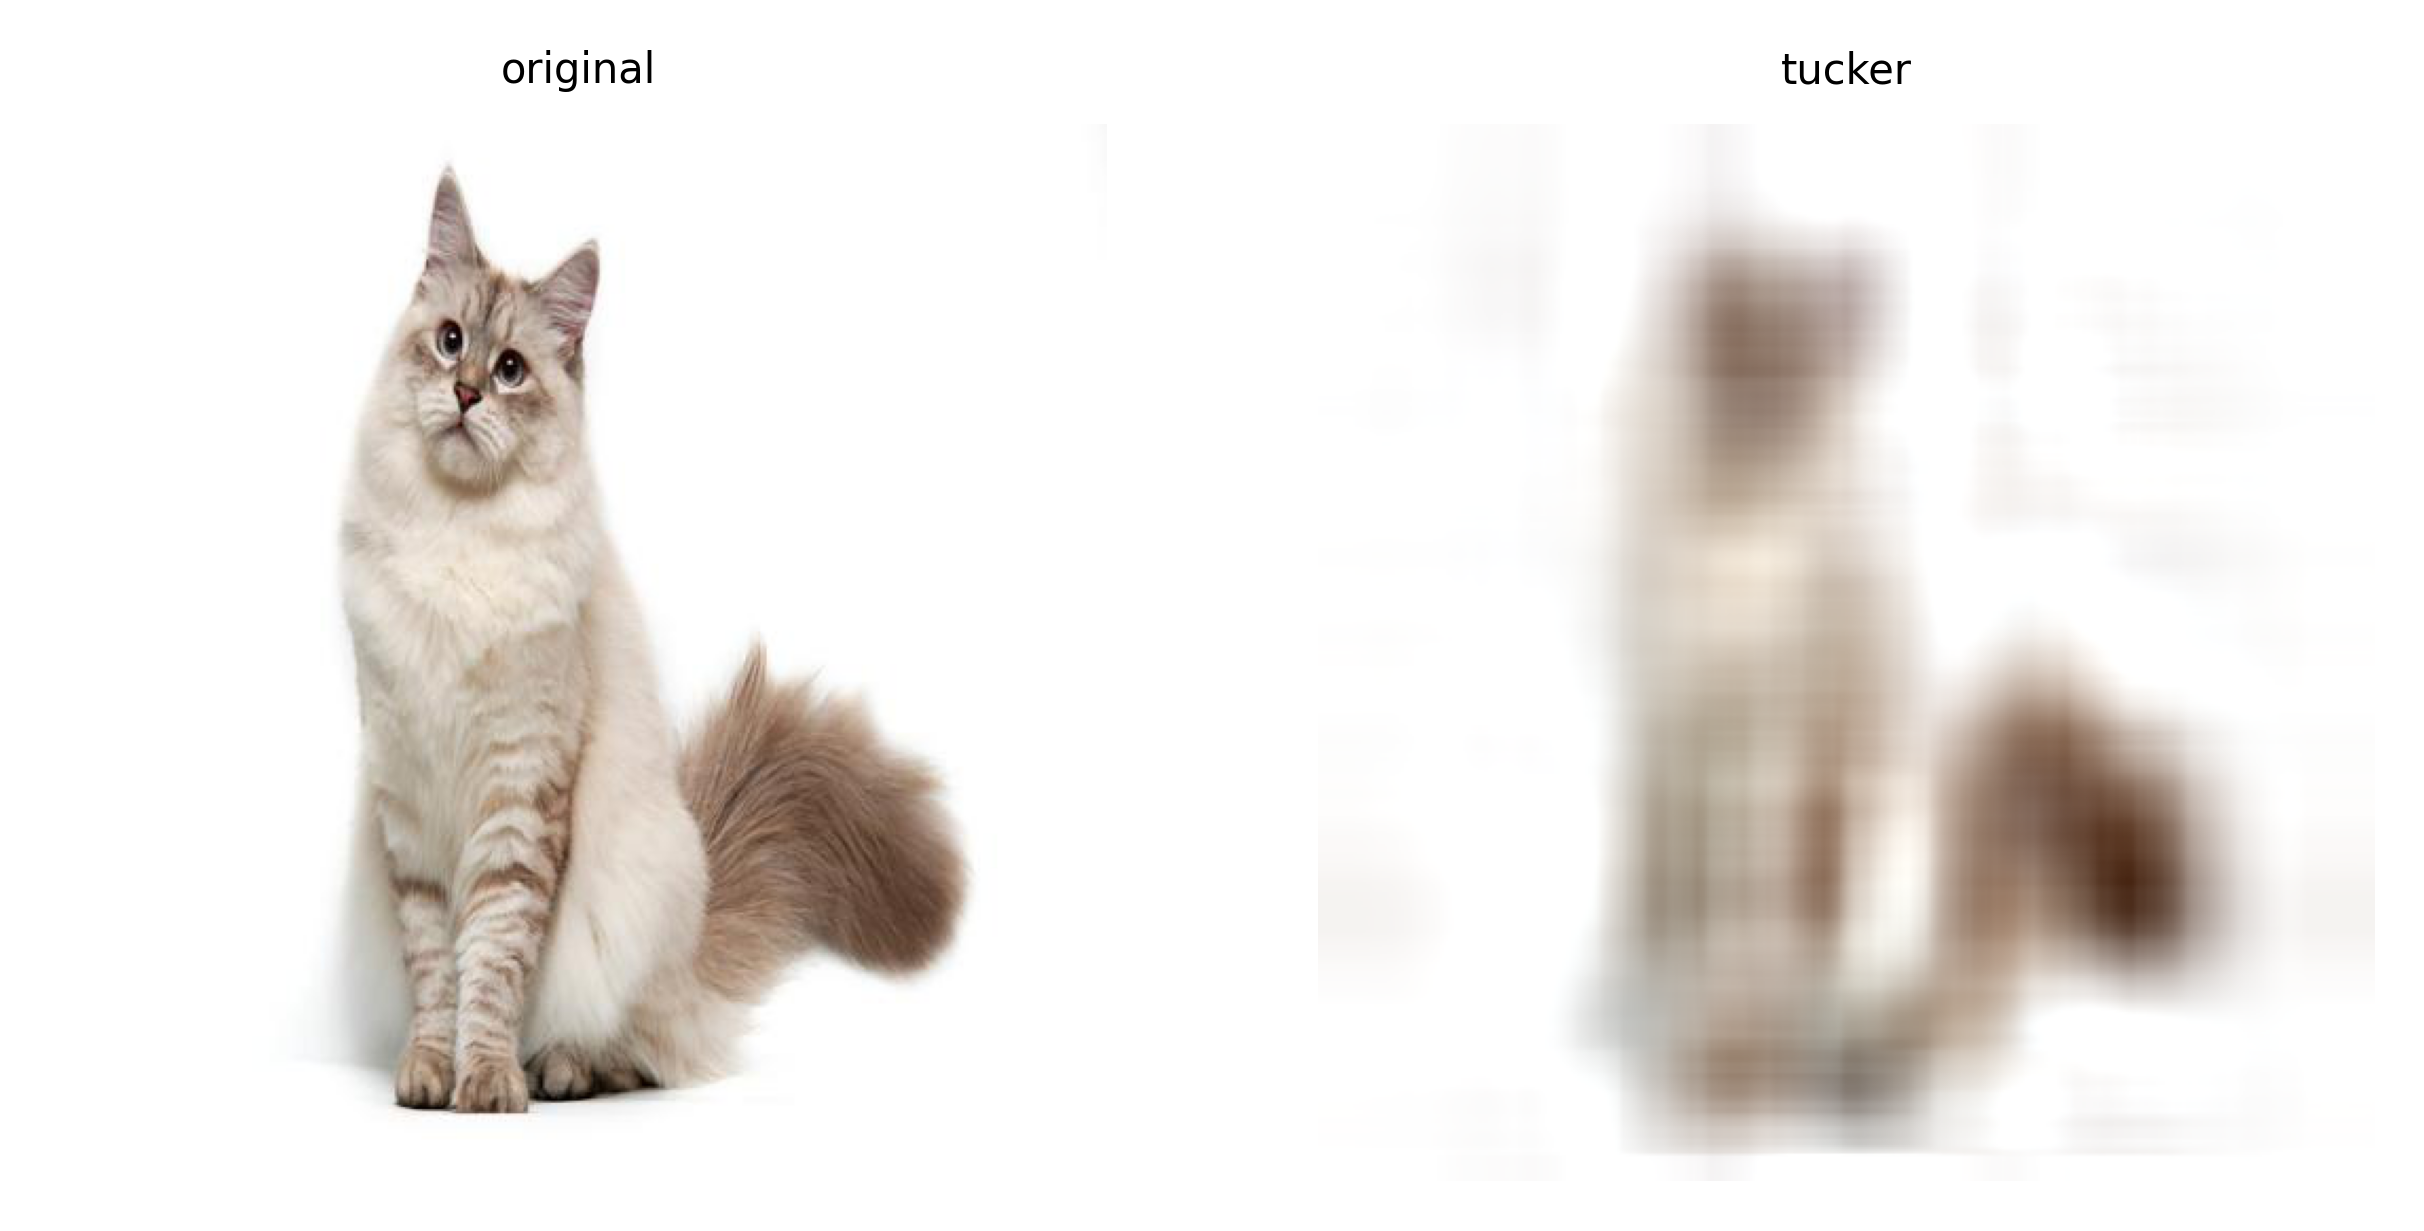

In [981]:
# visualize one image to check 
X_train_ = tl.tenalg.multi_mode_dot(G_train[:,:,:,0], A[:-1], transpose=False)  

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(images_train[0])
ax[0].axis('off')
ax[0].set_title('original', size=6)
ax[1].imshow(X_train_.astype(int))
ax[1].axis('off')
ax[1].set_title('tucker', size=6)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


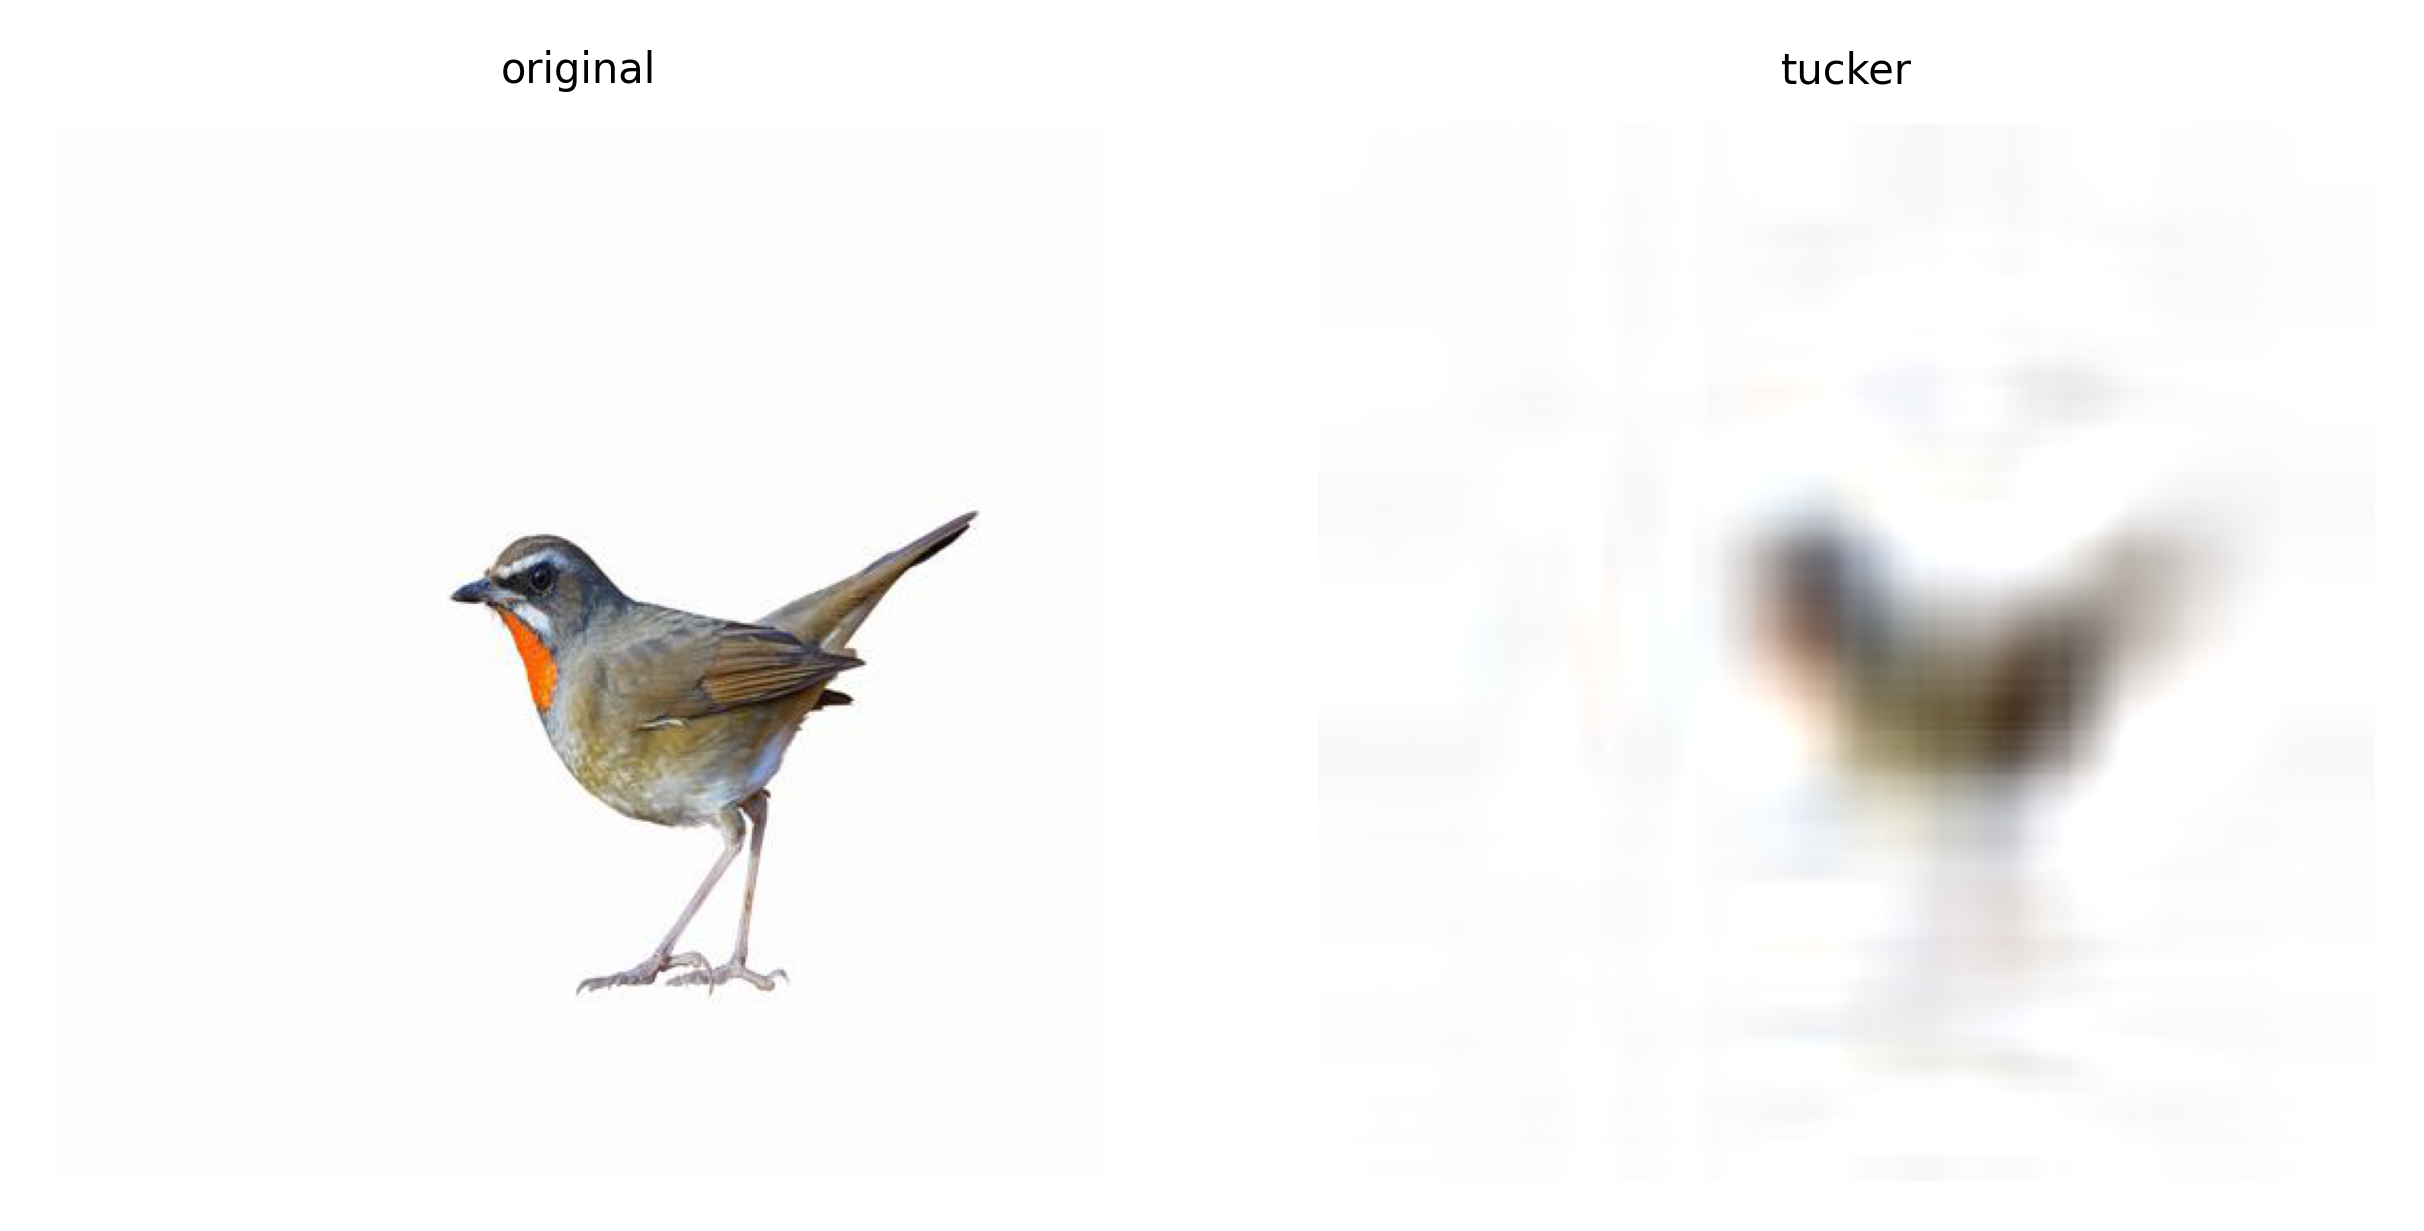

In [982]:
# visualize one test image to check 
X_test_ = tl.tenalg.multi_mode_dot(G_test[:,:,:,0], A[:-1], transpose=False)  

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(images_test[0])
ax[0].axis('off')
ax[0].set_title('original', size=6)
ax[1].imshow(X_test_.astype(int))
ax[1].axis('off')
ax[1].set_title('tucker', size=6)
plt.show()

It is expected that the tucker image is blurry. We reduced the dimensions from `500 x 500 = 250000` to `10x10=100` for each image.

In [949]:
# convert to (100, n_sample)
G_train = G_train.reshape(300, G_train.shape[3]).T  # 28 samples, each has 100 features 
G_test = G_test.reshape(300, G_test.shape[3]).T

In [950]:
# train random forest classifier 
model = RandomForestClassifier(random_state=1, max_depth=20, n_estimators=100, max_features=1) 
model.fit(G_train, y_train)

# predict on test data
pred_train = model.predict(G_train)
pred_test = model.predict(G_test)
print("Train accuracy:", np.sum(pred_train == y_train) / y_train.shape[0])
print("Test accuracy:", np.sum(pred_test == y_test) / y_test.shape[0])
confusion_matrix(y_test, pred_test)

Train accuracy: 1.0
Test accuracy: 1.0


array([[6, 0],
       [0, 6]])

Using gray scale images, the test classification accuracy was 0.92. Using color images, the test classification accuracy increased to 1.0. So colors seems to capture more information and achieve better accuracy, at the expense of higher computation complexity.